- Input your's drive_path for further input use, upload all required csv files into the folder defined by drive_path

Yan's Drive Path Below:

In [ ]:
drive_path = '/content/drive/MyDrive/ColabNotebooks/PIC16B/ProjectFinal/'

Chelsea's Drive Path Below:

In [ ]:
drive_path = '/content/drive/MyDrive/'

Guanzhang's Drive Path Below:

In [ ]:
drive_path = '/content/drive/MyDrive/'

Install snscrape:

In [ ]:
pip install snscrape

# Sentiment Analysis Final Version

Stock Volatility is correlated with market sentiments, which affects the performance. Therefore, sentimental analysis should be also considered when doing stock prediction.

Possible sentiments to be considered in this project are online comments from websites like twitter and reddit, and stock analysts records websites such as tipranks.

This notebook is trying to find a relative optimal way to do the sentiment analysis. Specifically, as there are many websites for choosing, how it differs between the choices of websites as well as the time period of retrieving?

For analyzing the correct usage of sentiments, we'll use the ticker 'AAPL' in this entire notebook.

First, import all required packages.

In [ ]:
import pandas_datareader.data as reader
import datetime as dt
import pandas as pd
import numpy as np
import urllib, json
import httplib2
import time

import snscrape.modules.twitter as sntwitter

import tensorflow as tf
import re
import string

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow import keras
from bs4 import BeautifulSoup

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from matplotlib import pyplot as plt

import plotly.express as px

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import pydot
import graphviz

import bs4 as bs
import pickle
import requests

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Retrieve Sentiments from Webpages

First, let's define some functions to retrieve sentiments from commonly used websites (yahoo_finance, twitter, reddit, tiprank).

### 1. Stock Returns

The data is retrieved from yahoo_finance

preparation function: `get_prices()`

- this is the fundamental level prep function

In [ ]:
def get_prices(tickers, begin, end):
    """
    A function retrieving daily price changes between a specified peiod of time using Yahoo Finance.
    
    Input
    --------
    tickers: list of tickers the user want to retrieve returns for
    begin: dt.datetime object, the beginning of the time period
    end: dt.datetime object, the end of the time period
    
    Output
    --------
    A dataframe containing the daily price change, tikcers and dates
    """
    # Initialize the container
    data = []
    # For all tickers
    for ticker in tickers:
        # Retieve the daily price using the yahoo finance module
        de = reader.get_data_yahoo(ticker,begin,end)[['Adj Close']]
        data.append(de)
    # Concat the data into a single dataframe
    result = pd.concat(data, axis = 1)
    # Set the names of the columns to be the tickers
    result.columns = tickers
    # Calculate the daily price changes reset the indices
    result = result.pct_change().dropna().reset_index()
    
    return result

main function: `return_input()`

- this function uses the above preparation function

- create a dataframe of previous five day daily returns specified by the begin and end date of retrieving, and outputs the dataframe that could be potentially used by the Tensorflow dataset

In [ ]:
def return_input(ticker, begin, end):
    """
    A function that returns a lagged version of daily price changes input for a specific ticker over a certain period.
    
    Input
    --------
    ticker: string, the stock ticker
    begin: dt.datetime object, the beginning of the time period
    end: dt.datetime object, the end of the time period
    
    Output
    --------
    A dataframe containing a lagged version of daily price changes input for a specific ticker over a certain period
    """
    # Retrieve the daily returns for all tradedays in the period, note that there are holidays and weekends, we handle this by retrieving
    # also data further away before the beginning of the time period and drop them at the end
    df = get_prices([ticker], begin - dt.timedelta(days = 10), end - dt.timedelta(days = 1))
    df["Ticker"] = ticker
    df = df.rename(columns = {ticker: "Return"})
    # Note that we didn't retrieve the returns for the lat day, in order for the lag function to consider the last day
    # We add an extra row
    last_day = pd.DataFrame({"Date": end,"Return":np.NaN, "Ticker": ticker}, index=[0])
    df = pd.concat([df,last_day], ignore_index = True)
    # Do the lag for 5 days
    for i in range(1,6):
        df["Return " + str(i) + " Days Before"] = df.groupby("Ticker")["Return"].transform(lambda x: lag(x, i))
    # Drop the data before the beginning of the time period
    df = df[df["Date"] >= begin].copy().reset_index(drop = True)
    
    return df

Now, showing a example on how retrieving from yahoo_finance results into a dataset.

In [ ]:
ticker = "AAPL"
begin = dt.datetime(2021,3,1)
end = dt.datetime(2021,3,30)

returns = return_input(ticker, begin, end)

In [ ]:
returns

,Date,Return,Ticker,Return 1 Days Before,Return 2 Days Before,Return 3 Days Before,Return 4 Days Before,Return 5 Days Before
5,2021-03-01,0.053851,AAPL,0.002232,-0.034783,-0.004052,-0.001111,-0.029799
6,2021-03-02,-0.020894,AAPL,0.053851,0.002232,-0.034783,-0.004052,-0.001111
7,2021-03-03,-0.024457,AAPL,-0.020894,0.053851,0.002232,-0.034783,-0.004052
8,2021-03-04,-0.015812,AAPL,-0.024457,-0.020894,0.053851,0.002232,-0.034783
9,2021-03-05,0.010738,AAPL,-0.015812,-0.024457,-0.020894,0.053851,0.002232
10,2021-03-08,-0.041673,AAPL,0.010738,-0.015812,-0.024457,-0.020894,0.053851
11,2021-03-09,0.040650,AAPL,-0.041673,0.010738,-0.015812,-0.024457,-0.020894
12,2021-03-10,-0.009167,AAPL,0.040650,-0.041673,0.010738,-0.015812,-0.024457
13,2021-03-11,0.016503,AAPL,-0.009167,0.040650,-0.041673,0.010738,-0.015812
14,2021-03-12,-0.007625,AAPL,0.016503,-0.009167,0.040650,-0.041673,0.010738


### 2. Reddit

preparation function 1: `prepare_reddit()`

- this is the fundamental level of prep function

In [ ]:
def prepare_reddit(l):
    '''
    Loop through the data and extract score, id, created time,
    and text body of reddits posts about the stock and put them
    into a dictionary, and cast it into a pandas data frame
    
    Input
    --------
    json loaded content data on one webpage api

    Output
    --------
    a dataframe containing stock data including score, id, created time, and text body
    '''
    # create an empty dict to append information on
    topics_dict = {"score":[],
                   "id":[], 
                   # "url":[],
                   "created": [],
                   "body":[]}
    # append all the information retrieved from the json.loads()
    for d in l:
        topics_dict["score"].append(d['score'])
        topics_dict["id"].append(d['id'])
        topics_dict["created"].append(d['author'])
        topics_dict["body"].append(d['body'])
        # a small note: here body represents the text of each
        # retrieved reddit comments
    # return the dict as a dataframe
    return pd.DataFrame(topics_dict)

preparation function 2: `get_reddit()`

- this function uses prep function 1

In [ ]:
def get_reddit(ticker, date_after, date_before):
    '''
    Turn start date and end date to the form of how many days from now,
    so they can be used to specify the url that leads to data, and then 
    use the helper function prepare_reddit() to retrieve reddit posts about 
    a stock in the time period between the specified start date and end date
    
    Input
    --------
    ticker: list, ticker names of stocks
    date_after: dt.datetime, start date to retrieve from
          (consider the end at 0:00 of that day)
    date_before: dt.datetime, end date to retrieve from

    Output
    --------
    a dataframe containing data related to the specified stock
    '''
    # specify start date days to today to retrieve
    after = (dt.datetime.now() - date_after).days
    # specify end date days to today to retrieve
    before = (dt.datetime.now() - date_before).days
    # retrieve the url by specified the two values of "before today"
    url = f"https://api.pushshift.io/reddit/search/comment/?q={ticker.lower()}&subreddit=wallstreetbets&before={before}d&after={after}d&size=500"
    
    # read response from url
    response = urllib.request.urlopen(url)
    # use json to load the content out as dict of dicts
    de = json.loads(response.read())
    # use the data sub-dict in the retrieved content dict
    # and use prep function 1 to prepare the dataset
    df = prepare_reddit(de['data'])

    # return the dataset
    return df

preparation function 3: `get_reddits_body()`

- this function uses prep function 2

In [ ]:
def get_reddits_body(ticker, date):
    '''
    Make use of the helper function retrieve all reddits comments 
    on one stock in one day, and extract the texts that are posted
    in the specified week and combine them into one text string

    Input
    --------
    ticker: list, ticker names of stocks
    date: dt.datetime, the date to retrieve from
          (consider the end at 0:00 of that day)
    
    Output
    --------
    text: string, all reddits texts (concatenated) that is
          targeted to the ticker in a whole day
          (from 0:00 date-1 to 0:00 date)
    '''
    # create empty string to concatenate comments on
    text = ''
    # define end time as "0:00 date"
    until = date
    # define start time as "0:00 date-1"
    since = date - dt.timedelta(days = 1)
    # so that we now have the whole 24h before "date" to retrieve from
    # print(since, until) # this line could be used to check time periods

    # now, use get_reddit to retrieve the dataframe
    # remember texts are in the "body" column
    df = get_reddit(ticker, since, until)
    # append all reddit texts to the "text" variable
    for content in df["body"]:
        text += content
        text += " " # for separating different texts

    # return the concatenated whole string
    return text

main function: `reddits_input()`

- this function uses prep function 3

- create a dataframe of daily reddit comments specified by the begin and end date of retrieving, and outputs the dataframe that could be potentially used by the Tensorflow dataset

In [ ]:
def reddits_input(ticker, begin, end):
    '''
    Create a dataframe with each row entry represents
    reddit comments of each day within the begin and end
    date time periods.

    Input
    --------
    tickers: a ticker the user want to retrieve returns for
    begin: dt.datetime object, the beginning of the time period
    end: dt.datetime object, the end of the time period
    
    Output
    --------
    A dataframe containing the date, ticker of reddit comments,
    as well as the 1 day before texts and 2 day before texts
    '''

    # four keys needed for the prep dict
    reddits_input = {"Date":[],
                   "Ticker":[],
                   "Reddits 1 Days Before": [],
                   "Reddits 2 Days Before": []}
    # first, define date as begin
    date = begin
    # loop through until reach end date
    while(date <= end):
        reddits_input["Date"].append(date)
        reddits_input["Ticker"].append(ticker)
        # retrieve comments 1 day before "date"
        comments_1d = get_reddits_body(ticker, date)
        reddits_input["Reddits 1 Days Before"].append(comments_1d)
        time.sleep(1) # used for avoiding HTTP Error 429
        # retrieve comments 2 day before "date"
        comments_2d = get_reddits_body(ticker, date - dt.timedelta(days = 1))
         reddits_input["Reddits 2 Days Before"].append(comments_2d)
        time.sleep(1) # used for avoiding HTTP Error 429
        date += dt.timedelta(days = 1) # loop to next day

    # return the dict as the desired dateframe
    return pd.DataFrame(reddits_input)

Now, showing a example on how retrieving from reddit results into a dataset.

In [ ]:
ticker = "AAPL"
begin = dt.datetime(2021,3,1)
end = dt.datetime(2021,3,30)

reddits = reddits_input(ticker, begin, end)

In [ ]:
reddits

,Date,Ticker,Reddits 1 Days Before,Reddits 2 Days Before
0,2021-03-01,AAPL,,
1,2021-03-02,AAPL,AAPL why are you the way you are? If you don’t...,
2,2021-03-03,AAPL,"Woohoo aapl, WEN, SQQQ all going so well! Don’...",AAPL why are you the way you are? If you don’t...
3,2021-03-04,AAPL,I only have aapl and it has been raping me las...,"Woohoo aapl, WEN, SQQQ all going so well! Don’..."
4,2021-03-05,AAPL,Citadel holds like what... 10k stocks? So are ...,I only have aapl and it has been raping me las...
5,2021-03-06,AAPL,,Citadel holds like what... 10k stocks? So are ...
6,2021-03-07,AAPL,Got caught up using too much margin for shares...,
7,2021-03-08,AAPL,"tech on sale. aapl is safe for the long run, t...",Got caught up using too much margin for shares...
8,2021-03-09,AAPL,"$aapl Buying calls here... I bought AMD, QQQ, ...","tech on sale. aapl is safe for the long run, t..."
9,2021-03-10,AAPL,Aapl making me $cum at $122 AAPL pile driving ...,"$aapl Buying calls here... I bought AMD, QQQ, ..."


### 3. Twitter

preparation function 1: `get_tweets()`

- this is the fundamental level of prep function

In [ ]:
def get_tweets(tickers, begin, end):
    """
    A function retrieving tweets between a specified peiod of time. For each given day, only 20000 characters of tweets will be retrieved at maximum.
    
    Input
    --------
    tickers: list of tickers the user want to scrape for tweets
    begin: dt.datetime object, the beginning of the time period
    end: dt.datetime object, the end of the time period
    
    Output
    --------
    A dataframe containing the tweets, tikcers and dates
    """
    # Initialize the container
    data = []
    # For all tickers 
    for ticker in tickers:
        # Initialize a tracker for the while loop
        date = begin
        # For all days in the time period
        while date < end + dt.timedelta(days = 1):
            # Set the time mark for that specific day
            d1 = date
            d2 = date + dt.timedelta(days = 1)
            # Container for tweets
            tweets = ''
            # Tracking the length of tweet
            length = 0
            # Retrieve relevant tweets on that speicifc day
            for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'{ticker} since:{d1.year}-{d1.month}-{d1.day} until:{d2.year}-{d2.month}-{d2.day}').get_items()):
                # Exclude those tweets if the ticker appears in the userid
                if ticker not in tweet.username.lower():
                    # Add the tweets to the container
                    tweets += tweet.content
                    # Update the length
                    length += len(tweet.content)
                # If we have reached our targeted length
                if length > 20000:
                    # Exit the loop
                    break
            # Construct a dataframe containing the tweets, the ticker and the date
            df = pd.DataFrame({"Tweets": [tweets]})
            df["Date"] = date
            df["Ticker"] = ticker
            
            # Append the dataframe to the container
            data.append(df)
            # Update the date
            date += dt.timedelta(days = 1)
    # Convert the container to a mega dataframe and return
    result = pd.concat(data, ignore_index = True)
    return result

preparation function 2: `lag()`

- this is the fundamental level of prep function

In [ ]:
def lag(x, num_places):
    """
    Shifts the array x by num_places positions to the right,
    Fills positions now empty with np.nan values,
    Returns the shifted array.
    
    Input
    --------
    x: 1d array of float types
    num_places: int type, number of positions to shift the array
    
    Output
    --------
    y: 1d array after the shift
    """
    # Shift the array by num_places positions
    new = np.roll(x, num_places)
    # Fill the emptied positions with np.nan
    new[0:num_places] = np.nan

    # Return the shifted array
    return new

main function: tweets_input

- this function uses prep function 1 and 2

- create a dataframe of daily twitter comments specified by the begin and end date of retrieving, and outputs the dataframe that could be potentially used by the Tensorflow dataset

In [ ]:
def tweets_input(ticker, begin, end):
    """
    A function that returns a lagged version of tweets input for a specific ticker over a certain period.
    
    Input
    --------
    ticker: string, the stock ticker
    begin: dt.datetime object, the beginning of the time period
    end: dt.datetime object, the end of the time period
    
    Output
    --------
    A dataframe containing a lagged version of tweets input for a specific ticker over a certain period
    """
    # Retrieve all tweets in the given period of time
    df = get_tweets([ticker], begin - dt.timedelta(days = 2), end - dt.timedelta(days = 1))
    # Note that we didn't retrieve the tweets for the lat day, in order for the lag function to consider the last day
    # We add an extra row
    last_day = pd.DataFrame({"Date": end,"Tweets": '',"Ticker": ticker}, index=[0])
    df = pd.concat([df,last_day], ignore_index = True)
    # Do the lag for two days
    for i in range(1,3):
        df["Tweets " + str(i) + " Days Before"] = df.groupby("Ticker")["Tweets"].transform(lambda x: lag(x, i))
    # Drop the tweets for the given day
    df = df.drop("Tweets", axis = 1)
    # Dropna and reset the indices
    df = df.dropna().reset_index(drop = True)
    return df

Now, showing a example on how retrieving from twitter results into a dataset.

In [ ]:
ticker = "AAPL"
begin = dt.datetime(2021,3,1)
end = dt.datetime(2021,3,30)

tweets = tweets_input(ticker, begin, end)

In [ ]:
tweets

,Date,Ticker,Tweets 1 Days Before,Tweets 2 Days Before
0,2021-03-01,AAPL,Data Reveals 40% of Disney+ Subscribers Are in...,[Last 2 Hours]\n\nStocks trending among elite ...
1,2021-03-02,AAPL,"@ARKInvest Innovation ETF($ARKK): $SNAP -63%, ...",Data Reveals 40% of Disney+ Subscribers Are in...
2,2021-03-03,AAPL,@Trendtraderz @_JamesBradley__ I did a puts se...,"@ARKInvest Innovation ETF($ARKK): $SNAP -63%, ..."
3,2021-03-04,AAPL,$spx $tsla $aapl $msft $fb $pltr\n\nIt is poss...,@Trendtraderz @_JamesBradley__ I did a puts se...
4,2021-03-05,AAPL,$nio 36$ looks more attractive tomorrow maybe ...,$spx $tsla $aapl $msft $fb $pltr\n\nIt is poss...
5,2021-03-06,AAPL,Buy those tech stocks people\n They're on sale...,$nio 36$ looks more attractive tomorrow maybe ...
6,2021-03-07,AAPL,$AAPL yep.. 🤒 https://t.co/FMvyXTFsmL$AAPL\n長期...,Buy those tech stocks people\n They're on sale...
7,2021-03-08,AAPL,"Tech giants in brewing battle over tracking, a...",$AAPL yep.. 🤒 https://t.co/FMvyXTFsmL$AAPL\n長期...
8,2021-03-09,AAPL,@dougboneparth Scooping those $AAPL dips https...,"Tech giants in brewing battle over tracking, a..."
9,2021-03-10,AAPL,@zm_lopez Please do not compare Apple $AAPL an...,@dougboneparth Scooping those $AAPL dips https...


### 4. Tipranks

Since this section is optional in this file, we'll discuss it when coming to the Tiprank module.

For more information, refer to the section *More Insights: How Tiprank Could be Used Here* later in this file.

## Several Preparation Functions for Dataset Creation and Tensorflow Models

1. `train_test_split(data)`: doing the training test splitting of an inputting tensorflow dataset

2. `standardization(input_data)`: doing data standardization process, used for defining TextVectorization later in all models.

3. `select_trade_days(x, dates)`: selects all the rows in the DataFrame whose date is within the given list of tradedays

4. `identify_trade_days(x, dates)`: helper function for select_trade_days, mark the dataframe rows if the date is within the given list of tradedays

5. `remove_stopwords(df_pd, colname, stopwords_list)`: remove stopwords inside text columns that is defined by *colname* columns in *df_pd*

In [ ]:
def train_test_split(data):
    """
    Split a tensorflow dataset into 80:20 train:validation,
    and output train and validation
    
    Input
    --------
    dataset: the whole tensorflow dataset
    
    Output
    --------
    (train, val): training and validation datasets
    """
    np.random.seed(9999)

    data = data.shuffle(buffer_size = len(data))

    train_size = int(0.8*len(data))
    val_size   = int(0.2*len(data))
    
    train = data.take(train_size)
    val   = data.skip(train_size).take(val_size)
    
    return train, val

In [ ]:
def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation

In [ ]:
def identify_trade_days(x, dates):
    """
    A function to mark the dataframe rows if the date is within the given list of tradedays
    
    Input
    --------
    x: DataFrame object grouped by Date
    dates: list of tradedays as dt.datetime object
    
    Output
    --------
    The dataframe with rows marked, 1 in the TD column means the row is data from a tradeday and 0 otherwise
    """
    # If the date is a tradeday
    if x["Date"].values[0] in dates:
        # Mark the row accordingly
        x["TD"] = 1
    # If the date is not a tradeday
    else:
        # Mark the row acoordingly
        x["TD"] = 0
        
    return x

def select_trade_days(x, dates):
    """
    A function that selects all the rows in the DataFrame whose date is within the given list of tradedays
    
    Input
    --------
    x: DataFrame object grouped by Date
    dates: list of tradedays as dt.datetime object
    
    Output
    --------
    The part of the dataframe whose dates are tradedays
    """
    # Mark the rows to identify the trade days
    df = x.groupby("Date").apply(identify_trade_days, dates = dates)
    # Drop all the non-tradedays
    df = df[df["TD"] == 1].copy().reset_index(drop = True)

    # Return the result
    return df.drop("TD", axis = 1)

In [ ]:
def remove_stopwords(df_pd, colname, stopwords_list):
    """
    The function looks at the column df_pd[colname] in the input dataframe df_pd,
    and first change all characters to lowercase, 
    split texts into a list of word chunks according to empty space,
    and then reconcatenate the word chunks that are not in the list of stopwords stopwords_list
    into a string of texts again.

    Limitation: this function does not deal with stopwords right before punctuation marks.
    """
    all_words_in_list = df_pd[colname].str.lower().str.split()
    stopwords_removed = all_words_in_list.apply(lambda x: ' '.join([word for word in x if word.lower() not in stopwords_list]))

    return stopwords_removed

## Model 1: Reddit-Twitter One Day Only Analysis

This model takes predictors as:
- returns in the past 5 days
- reddit comments from 1 day ago
- twitter comments from 1 day ago

We want to visualize the model performance.



### Data Preparation

In [ ]:
def reddit_twitter_tensorflow_dataset(ticker, begin, end):

    """
    Prepare for Reddit-Twitter Combined Tensorflow Dataset.

    Input
    --------
    ticker: string, the stock ticker
    begin: dt.datetime object, the beginning of the time period
    end: dt.datetime object, the end of the time period

    Output
    --------
    data: Tensorflow dataset
        - predictors: tweets and reddit comments one day before
                      previous five days returns
        - target: the return of the current day
    """
    
    reddits = reddits_input(ticker, begin, end)
    tweets = tweets_input(ticker, begin, end)
    returns = return_input(ticker, begin, end)
    
    dates = returns["Date"].tolist()
    reddits = select_trade_days(reddits, dates)
    tweets = select_trade_days(tweets, dates)
    
    stopwords_list = stopwords.words("english")  # a list of stopwords in english
    tweets["Tweets 1 Days Before"] = remove_stopwords(tweets, "Tweets 1 Days Before", stopwords_list)
    reddits["Reddits 1 Days Before"] = remove_stopwords(reddits, "Reddits 1 Days Before", stopwords_list)

    temp = pd.merge(returns, tweets)
    df = pd.merge(temp, reddits)
    columns = ["Return " + str(i) + " Days Before" for i in range(1,6)]
    
    data = tf.data.Dataset.from_tensor_slices(
        (
            {
                "Tweets" : df[["Tweets 1 Days Before"]], 
                "Reddits" : df[["Reddits 1 Days Before"]], 
                "Previous_Returns": df[columns]
            }, 
            {
                "Returns" : df[["Return"]]
            }
        )
    )

    return data

In [ ]:
# retrieve all data from 2021/03/01 to 2021/04/30 for analyzation
data = reddit_twitter_tensorflow_dataset("AAPL", dt.datetime(2021,3,1), dt.datetime(2021,4,30))
train, val = train_test_split(data)

In [ ]:
size_vocabulary = 2000

vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500) 

vectorize_layer.adapt(train.map(lambda x, y: x["Reddits"]))
vectorize_layer.adapt(train.map(lambda x, y: x["Tweets"]))

### Model Construction

In [ ]:
rd_input = keras.Input(
    shape = (1,), 
    name = "Reddits",
    dtype = "string"
)

tw_input = keras.Input(
    shape = (1,), 
    name = "Tweets",
    dtype = "string"
)

re_input = keras.Input(
    shape = (5,), 
    name = "Previous_Returns",
    dtype = "float64"
)

In [ ]:
embedding_layer = layers.Embedding(input_dim = size_vocabulary, output_dim = 10)

# vectorize title texts into tensor containing data
rd_features = vectorize_layer(rd_input)
# Turns positive integers (indexes) into dense vectors of fixed size
rd_features = embedding_layer(rd_features)
# Applies Dropout to the input to avoid overfitting
rd_features = layers.Dropout(rate = 0.2)(rd_features)
# pooling To reduce variance, reduce computation complexity
rd_features = layers.GlobalAveragePooling1D()(rd_features)
# Applies Dropout to the input to avoid overfitting
rd_features = layers.Dropout(rate = 0.2)(rd_features)
# add a dense layer
rd_features = layers.Dense(32, activation = "relu", name = "reddit_dense")(rd_features)

# vectorize title texts into tensor containing data
tw_features = vectorize_layer(tw_input)
# Turns positive integers (indexes) into dense vectors of fixed size
tw_features = embedding_layer(tw_features)
# Applies Dropout to the input to avoid overfitting
tw_features = layers.Dropout(rate = 0.2)(tw_features)
# pooling To reduce variance, reduce computation complexity
tw_features = layers.GlobalAveragePooling1D()(tw_features)
# Applies Dropout to the input to avoid overfitting
tw_features = layers.Dropout(rate = 0.2)(tw_features)
# add a dense layer
tw_features = layers.Dense(32, activation = "relu", name = "tweets_dense")(tw_features)

combined_features = layers.concatenate([rd_features, tw_features], axis = 1)
combined_features = layers.Dense(32, activation='relu')(combined_features)

re_features = layers.Dense(32, activation='relu')(tf.reshape(re_input, [-1, 5]))
re_features = layers.Dense(16, activation='relu')(re_features)

# concatenate and create output
main = layers.concatenate([rd_features, tw_features, re_features], axis = 1)
main = layers.Dense(32, activation='relu')(main)
output = layers.Dense(1, name = "Returns")(main)

In [ ]:
rd_tw_model = keras.Model(
    inputs = [rd_input, tw_input, re_input],
    outputs = output
)

In [ ]:
rd_tw_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Reddits (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
Tweets (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 500)          0           Reddits[0][0]                    
                                                                 Tweets[0][0]                     
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 10)      20000       text_vectorization[0][0]     

### Model Result

In [ ]:
#complie
rd_tw_model.compile(optimizer = "adam",
              loss = losses.MeanSquaredError(),
              metrics = keras.metrics.MeanSquaredError()
)

# train
rd_tw_history = rd_tw_model.fit(train, 
                    validation_data=val,
                    epochs = 30,
                    verbose = False)

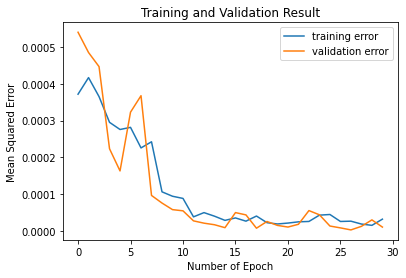

In [ ]:
plt.plot(rd_tw_history.history["mean_squared_error"], label = "training error")
plt.plot(rd_tw_history.history["val_mean_squared_error"], label = "validation error")
plt.xlabel('Number of Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Result')
plt.legend()

The Reddit-Twitter model seems to converge and works well.

## Model 2: One-day and Two-day Previous Reddits Analysis

This model takes predictors as:

- returns in the past 5 days
- reddit comments from 1 day ago
- reddit comments from 2 days ago

We want to visualize the model performance.

### Data Preparation

In [ ]:
def reddit_tensorflow_dataset(ticker, begin, end):
    """
    Prepare for Reddit-Only Combined Tensorflow Dataset.

    Input
    --------
    ticker: string, the stock ticker
    begin: dt.datetime object, the beginning of the time period
    end: dt.datetime object, the end of the time period

    Output
    --------
    data: Tensorflow dataset
        - predictors: reddit comments for one day and two day before
                      previous five days returns
        - target: the return of the current day
    """
    reddits = reddits_input(ticker, begin, end)
    returns = return_input(ticker, begin, end)
    
    dates = returns["Date"].tolist()
    reddits = select_trade_days(reddits, dates)
    
    stopwords_list = stopwords.words("english")  # a list of stopwords in english
    reddits["Reddits 1 Days Before"] = remove_stopwords(reddits, "Reddits 1 Days Before", stopwords_list)
    reddits["Reddits 2 Days Before"] = remove_stopwords(reddits, "Reddits 2 Days Before", stopwords_list)

    df = pd.merge(returns, reddits)
    columns = ["Return " + str(i) + " Days Before" for i in range(1,6)]
    
    data = tf.data.Dataset.from_tensor_slices(
        (
            {
                "Reddits_1" : df[["Reddits 1 Days Before"]], 
                "Reddits_2" : df[["Reddits 2 Days Before"]], 
                "Previous_Returns": df[columns]
            }, 
            {
                "Returns" : df[["Return"]]
            }
        )
    )

    return data

In [ ]:
# retrieve all data from 2021/03/01 to 2021/04/30 for analyzation
reddit_data = reddit_tensorflow_dataset("AAPL", dt.datetime(2021,3,1), dt.datetime(2021,4,30))
train, val = train_test_split(reddit_data)

In [ ]:
vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500) 

vectorize_layer.adapt(train.map(lambda x, y: x["Reddits_1"]))
vectorize_layer.adapt(train.map(lambda x, y: x["Reddits_2"]))

### Model Construction

In [ ]:
rd_input_1 = keras.Input(
    shape = (1,), 
    name = "Reddits_1",
    dtype = "string"
)

rd_input_2 = keras.Input(
    shape = (1,), 
    name = "Reddits_2",
    dtype = "string"
)

re_input = keras.Input(
    shape = (5,), 
    name = "Previous_Returns",
    dtype = "float64"
)

In [ ]:
embedding_layer = layers.Embedding(input_dim = size_vocabulary, output_dim = 10)

# vectorize title texts into tensor containing data
rd_features1 = vectorize_layer(rd_input_1)
# Turns positive integers (indexes) into dense vectors of fixed size
rd_features1 = embedding_layer(rd_features1)
# Applies Dropout to the input to avoid overfitting
rd_features1 = layers.Dropout(rate = 0.2)(rd_features1)
# pooling To reduce variance, reduce computation complexity
rd_features1 = layers.GlobalAveragePooling1D()(rd_features1)
# Applies Dropout to the input to avoid overfitting
rd_features1 = layers.Dropout(rate = 0.2)(rd_features1)
# add a dense layer
rd_features1 = layers.Dense(32, activation = "relu", name = "rd_dense1")(rd_features1)

# vectorize title texts into tensor containing data
rd_features2 = vectorize_layer(rd_input_2)
# Turns positive integers (indexes) into dense vectors of fixed size
rd_features2 = embedding_layer(rd_features2)
# Applies Dropout to the input to avoid overfitting
rd_features2 = layers.Dropout(rate = 0.2)(rd_features2)
# pooling To reduce variance, reduce computation complexity
rd_features2 = layers.GlobalAveragePooling1D()(rd_features2)
# Applies Dropout to the input to avoid overfitting
rd_features2 = layers.Dropout(rate = 0.2)(rd_features2)
# add a dense layer
rd_features2 = layers.Dense(32, activation = "relu", name = "tw_dense2")(rd_features2)

rd_features = layers.concatenate([rd_features1, rd_features2], axis = 1)
rd_features = layers.Dense(32, activation='relu')(rd_features)

re_features = layers.Dense(32, activation='relu')(tf.reshape(re_input, [-1, 5]))
re_features = layers.Dense(16, activation='relu')(re_features)

# concatenate and create output
main = layers.concatenate([rd_features1, rd_features2, re_features], axis = 1)
main = layers.Dense(32, activation='relu')(main)
output = layers.Dense(1, name = "Returns")(main)

In [ ]:
rd_model = keras.Model(
    inputs = [rd_input_1, rd_input_2, re_input],
    outputs = output
)

In [ ]:
rd_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Reddits_1 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
Reddits_2 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization_2 (TextVecto (None, 500)          0           Reddits_1[0][0]                  
                                                                 Reddits_2[0][0]                  
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 500, 10)      20000       text_vectorization_2[0][0] 

### Model Result

In [ ]:
#complie
rd_model.compile(optimizer = "adam",
              loss = losses.MeanSquaredError(),
              metrics = keras.metrics.MeanSquaredError()
)

# train
rd_history = rd_model.fit(train, 
                    validation_data=val,
                    epochs = 30, 
                    verbose = False)

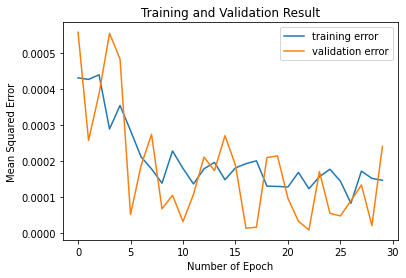

In [ ]:
plt.plot(rd_history.history["mean_squared_error"], label = "training error")
plt.plot(rd_history.history["val_mean_squared_error"], label = "validation error")
plt.xlabel('Number of Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Result')
plt.legend()

The Reddit-only model has very unstable, fluctuating validation errors. Moreover, it has higher training errors and validation errors compared to models that incorporate Tweet data. 

## Model 3: One-day and Two-day Previous Twitters Analysis

This model takes predictors as:

- returns in the past 5 days
- twitter comments from 1 day ago
- twitter comments from 2 days ago

We want to visualize the model performance.

### Data Preparation

In [ ]:
def twitter_tensorflow_dataset(ticker, begin, end):

    """
    Prepare for Reddit-Only Combined Tensorflow Dataset.

    Input
    --------
    ticker: string, the stock ticker
    begin: dt.datetime object, the beginning of the time period
    end: dt.datetime object, the end of the time period

    Output
    --------
    data: Tensorflow dataset
        - predictors: tweets for one day and two day before
                      previous five days returns
        - target: the return of the current day
    """

    tweets = tweets_input(ticker, begin, end)
    returns = return_input(ticker, begin, end)
    
    dates = returns["Date"].tolist()
    tweets = select_trade_days(tweets, dates)
    
    stopwords_list = stopwords.words("english")  # a list of stopwords in english
    tweets["Tweets 1 Days Before"] = remove_stopwords(tweets, "Tweets 1 Days Before", stopwords_list)
    tweets["Tweets 2 Days Before"] = remove_stopwords(tweets, "Tweets 2 Days Before", stopwords_list)

    df = pd.merge(returns, tweets)
    columns = ["Return " + str(i) + " Days Before" for i in range(1,6)]
    
    data = tf.data.Dataset.from_tensor_slices(
        (
            {
                "Tweets_1" : df[["Tweets 1 Days Before"]], 
                "Tweets_2" : df[["Tweets 2 Days Before"]], 
                "Previous_Returns": df[columns]
            }, 
            {
                "Returns" : df[["Return"]]
            }
        )
    )

    return data

In [ ]:
# retrieve all data from 2021/03/01 to 2021/04/30 for analyzation
twitter_data = twitter_tensorflow_dataset("AAPL", dt.datetime(2021,3,1), dt.datetime(2021,4,30))
train, val = train_test_split(twitter_data)

In [ ]:
# text vectorization
size_vocabulary = 2000

vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500) 

vectorize_layer.adapt(train.map(lambda x, y: x["Tweets_1"]))
vectorize_layer.adapt(train.map(lambda x, y: x["Tweets_2"]))

### Model Construction

In [ ]:
tw_input_1 = keras.Input(
    shape = (1,), 
    name = "Tweets_1",
    dtype = "string"
)

tw_input_2 = keras.Input(
    shape = (1,), 
    name = "Tweets_2",
    dtype = "string"
)

re_input = keras.Input(
    shape = (5,), 
    name = "Previous_Returns",
    dtype = "float64"
)

In [ ]:
embedding_layer = layers.Embedding(input_dim = size_vocabulary, output_dim = 10)

# vectorize title texts into tensor containing data
tw_features1 = vectorize_layer(tw_input_1)
# Turns positive integers (indexes) into dense vectors of fixed size
tw_features1 = embedding_layer(tw_features1)
# Applies Dropout to the input to avoid overfitting
tw_features1 = layers.Dropout(rate = 0.2)(tw_features1)
# pooling To reduce variance, reduce computation complexity
tw_features1 = layers.GlobalAveragePooling1D()(tw_features1)
# Applies Dropout to the input to avoid overfitting
tw_features1 = layers.Dropout(rate = 0.2)(tw_features1)
# add a dense layer
tw_features1 = layers.Dense(32, activation = "relu", name = "tw_dense1")(tw_features1)

# vectorize title texts into tensor containing data
tw_features2 = vectorize_layer(tw_input_2)
# Turns positive integers (indexes) into dense vectors of fixed size
tw_features2 = embedding_layer(tw_features2)
# Applies Dropout to the input to avoid overfitting
tw_features2 = layers.Dropout(rate = 0.2)(tw_features2)
# pooling To reduce variance, reduce computation complexity
tw_features2 = layers.GlobalAveragePooling1D()(tw_features2)
# Applies Dropout to the input to avoid overfitting
tw_features2 = layers.Dropout(rate = 0.2)(tw_features2)
# add a dense layer
tw_features2 = layers.Dense(32, activation = "relu", name = "tw_dense2")(tw_features2)

tw_features = layers.concatenate([tw_features1, tw_features2], axis = 1)
tw_features = layers.Dense(32, activation='relu')(tw_features)


re_features = layers.Dense(32, activation='relu')(tf.reshape(re_input, [-1, 5]))
re_features = layers.Dense(16, activation='relu')(re_features)

# concatenate and create output
main = layers.concatenate([tw_features1, tw_features2, re_features], axis = 1)
main = layers.Dense(32, activation='relu')(main)
output = layers.Dense(1, name = "Returns")(main)

In [ ]:
tw_model = keras.Model(
    inputs = [tw_input_1, tw_input_2, re_input],
    outputs = output
)

In [ ]:
tw_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tweets_1 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
Tweets_2 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization_4 (TextVecto (None, 500)          0           Tweets_1[0][0]                   
                                                                 Tweets_2[0][0]                   
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 500, 10)      20000       text_vectorization_4[0][0] 

### Model Result

In [ ]:
#complie
tw_model.compile(optimizer = "adam",
              loss = losses.MeanSquaredError(),
              metrics = keras.metrics.MeanSquaredError()
)

# train
tw_history = tw_model.fit(train, 
                    validation_data=val,
                    epochs = 30, 
                    verbose = False)

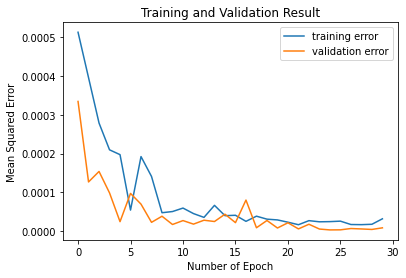

In [ ]:
plt.plot(tw_history.history["mean_squared_error"], label = "training error")
plt.plot(tw_history.history["val_mean_squared_error"], label = "validation error")
plt.xlabel('Number of Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Result')
plt.legend()

The Twitter-only model outperforms the Reddit-only model and the Reddit-Twitter model, with faster convergence and less fluctuation in errors. 

## General Result Comparison: Model 1 - 3

### Validation MSE Comparison

In order to do model comparison, we use the validation MSE as the determining index of the model accuracy.

In [ ]:
# retrieve validation mean squared error of reddit-twitter model (Ver 1)
rd_tw_val = rd_tw_history.history["val_mean_squared_error"]
# retrieve validation mean squared error of reddit-only model (Ver 2)
rd_12_val = rd_history.history["val_mean_squared_error"]
# retrieve validation mean squared error of twitter-only model (Ver 3)
tw_12_val = tw_history.history["val_mean_squared_error"]

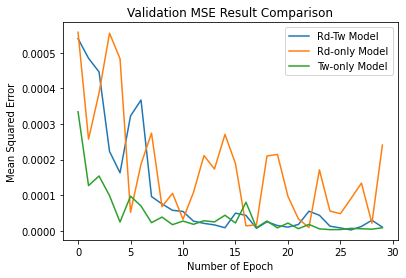

In [ ]:
plt.plot(rd_tw_val, label = "Rd-Tw Model")
plt.plot(rd_12_val, label = "Rd-only Model")
plt.plot(tw_12_val, label = "Tw-only Model")
plt.xlabel('Number of Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Validation MSE Result Comparison')
plt.legend()

**The result shows that after 10 epochs, the Reddit-Twitter and Twitter-only models are both somehow stablized compared to the Redit-only model. Therefore, we first exclude the Reddit-only model for consideration.**

**From the further comparison, the MSE is more stable for the Twitter-only model compared to the Reddit-Twitter model. To further confirm this finding clearly, we'll try to plot the MSE volatility for the two models. For simplicity and better visualization, use only the values after 10 epochs.**

### Validation MSE Volatility

In [ ]:
# 1. for reddit-twitter model, calculate MSE volatility
# use only epochs after 10
rd_tw_val = rd_tw_val[10:]
# create list recording volatility
rd_tw_vol = []
for i in np.arange(len(rd_tw_val) - 1):
    volatility = rd_tw_val[i+1] - rd_tw_val[i]
    rd_tw_vol.append(volatility)

# 2. for twitter-only model, calculate MSE volatility
# use only epochs after 10
tw_12_val = tw_12_val[10:]
# create list recording volatility
tw_12_vol = []
for i in np.arange(len(tw_12_val) - 1):
    volatility = tw_12_val[i+1] - tw_12_val[i]
    tw_12_vol.append(volatility)

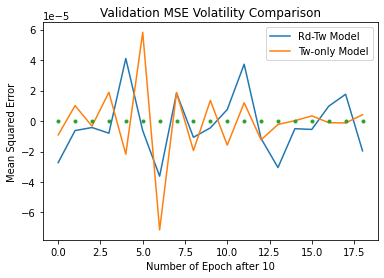

In [ ]:
plt.plot(rd_tw_vol, label = "Rd-Tw Model")
plt.plot(tw_12_vol, label = "Tw-only Model")
plt.plot(np.zeros(len(rd_tw_vol)), ".")
plt.xlabel('Number of Epoch after 10')
plt.ylabel('Mean Squared Error')
plt.title('Validation MSE Volatility Comparison')
plt.legend()

**The result shows that the volatility has a in general more stablized validation MSE for twitter-only model than reddit-twitter model, especially after 20 epochs.**

**Therefore, considering the fact that the MSE is reduced to a low level, and has stablized volatility, we decide to exclude Reddit data in out final model.**

## More Insights: How Trading Info Affects Here? (Discussion on Tiprank)

From the above models we've found that the two-day twitter model is the best model for predicting daily return so far. However, as commonly observed, daily trading information should affects the behaviour of daily return, and thus is also an important factor to be considered.

Tipranks is a website that contains basic stock analysts records. We are trying to find out whether there are any analytic records that could be used to gather trading information.

### Retrieve Data from Tiprank

First, make some preparation functions.

- downloadFile function basically download the contents in the webpage from url directly.

In [ ]:
def downloadFile(URL=None):
    """
    this function inputs an url and return the downloaded
    contents in the webpage as bytes typed output.
    """
    # import httplib2
    h = httplib2.Http(".cache")
    resp, content = h.request(URL, "GET")

    return content

Now comes to the second prep function:

Inside the tipranks website, there are direct webpages that stores all required market sentiments in the form similar to output of .js fles. For more reference on the form of javascript outputs, see the reference package [Tipranks.com API](https://github.com/janlukasschroeder/tipranks-api-v2).

The three example outputs are also posted as follows:

1.   [Ticker Specified Price Targets Info ('MU' here)](https://www.tipranks.com/api/stocks/getData/?name=MU)
2.   [Ticker Specified News Sentiments Info ('MU' here)](https://www.tipranks.com/api/stocks/getNewsSentiments/?ticker=MU)
3.   [Trending Stocks of a Specific Past Period (30 days here)](https://www.tipranks.com/api/stocks/gettrendingstocks/?daysago=30&which=most)

From the above urls, can see that the file contained inside is actually as versions of javascript outputs.

Therefore, write a function to decode bytes typed output provided in prep func 1, and then use json library to convert json typed output into python dict.

In [ ]:
def store_js_as_dict(url):
    """
    This function stores the json information inside the url webpage
    as a dict containing all informations of the json output
  
    Input
    --------
    url: the url with json contents inside it
  
    Output
    --------
    y: the desired dict containing all sentiments in the json file
    """
    x = downloadFile(url)
    x_json = x.decode()
    y = json.loads(x_json)

    return y

Now comes to the third preparation function.

Note: this function is only used for main function 1.

This function create and output a dict to store all information of a user-specified stock ticker from the Tiplink website.

In [ ]:
def ticker_tiprank_dict(ticker):
    """
    this function outputs all needed sentiments (news sentiments
    and price targets) of the company of the given stock ticker

    Input
    --------
    ticker: stock ticker of the targeting company
  
    Output
    --------
    d: the dict containing all needed sentiments
      - keys: getNewsSentiments, getPriceTarget
      - value of each key: news sentiments / price target of ticker
    """
    news_sentiments_url = "https://www.tipranks.com/api/stocks/getNewsSentiments/?ticker="+ticker
    price_target_url = "https://www.tipranks.com/api/stocks/getData/?name="+ticker

    sentiment_dict = store_js_as_dict(news_sentiments_url)
    price_dict = store_js_as_dict(price_target_url)
    d = {"getNewsSentiments": sentiment_dict, "getPriceTarget": price_dict}
    
    return d

#### Main Function 1: Tiprank Sentiments

This function requires an input argument of a list of ticker symbols, so the function can retrieve sentiment data and price data of all these stocks.

It returns a dictionary, with keys being each ticker symbol and values being a dictionary containing both news sentiment data and price data. Thus, these inner dictionaries have keys "getNewsSentiments" and "getPriceTarget", and their values are just data stored in inner-inner dictionaries. 


The news sentiment data include data such as buzz, sentiment, sector, and sector average bullish percent...... The price target data include data such as prices and yearly dividend......


**Level-I dict**   
**keys**: tickers  
**values**: Level-II dict  

**Level-II dict**  
**keys**: "getNewsSentiments", "getPriceTarget"  
**corresponding values**: Level-III dict 1, Level-III dict 2  

**Level-III dict 1**  
**keys**: "ticker", "companyName", "buzz", "sentiment", ...  

**Level-III dict 2**  
**keys**: "ticker", "prices", "consensuses", "yearlyDividendYield", ...  

In [ ]:
def tiprank_dict(input_tickers):
    """
    This function receives a list of targeting tickers as inputs,
    and returns a dict of dicts containing all needed information
    of all stock tickers provided by the user, with keys as each
    ticker, storing all sentimental information of the ticker.
  
    Input
    --------
    input_tickers: a list of targeting stock tickers

    Output
    --------
    d: a dict containing all sentimental information of all tickers
      - keys: input stock tickers
      - value of each key: ticker_tiprank_dict(key)
    """
    d = {}
    for ticker in input_tickers:
        d[ticker] = ticker_tiprank_dict(ticker)

    return d

Here are some sample outputs of this function:

Structure of Output: **{ stockTicker: { ‘getNewsSentiments’: a dictionary of news sentiment data, ‘getPriceTarget’: a dictionary of price target data } }**

In [ ]:
# get data for the stocks listed below
example_input = ['AAPL', 'MSFT', 'F', 'CRM', 'AMGN', 'TSLA', 'ARKK', 'AMD']
tiprank_example = tiprank_dict(example_input)

In [ ]:
# structure of the dictionary returned from tiprank_dict() with example_input
[(key, type(tiprank_example[key])) for key in tiprank_example.keys()][1:7]  # first 6 keys and their values

[('MSFT', dict),
 ('F', dict),
 ('CRM', dict),
 ('AMGN', dict),
 ('TSLA', dict),
 ('ARKK', dict)]

In [ ]:
# structure of inner dictionaries for each target stock 
[(key, type(tiprank_example["AAPL"][key])) for key in tiprank_example["AAPL"].keys()]

[('getNewsSentiments', dict), ('getPriceTarget', dict)]

In [ ]:
# structure of inner inner dictionaries for news sentiment for one target stock 
[(key, type(tiprank_example["AAPL"]["getNewsSentiments"][key])) for key in tiprank_example["AAPL"]["getNewsSentiments"].keys()]

[('ticker', str),
 ('companyName', str),
 ('buzz', dict),
 ('sentiment', dict),
 ('sector', list),
 ('sectorAverageBullishPercent', float),
 ('score', float),
 ('wordCloud', list),
 ('counts', list),
 ('sectorId', int),
 ('creationDate', str),
 ('sectorAverageNewsScore', float)]

In [ ]:
# structure of inner inner dictionaries for price for one target stock 
[(key, type(tiprank_example["AAPL"]["getPriceTarget"][key])) for key in tiprank_example["AAPL"]["getPriceTarget"].keys()]

[('ticker', str),
 ('companyName', str),
 ('companyFullName', str),
 ('stockUid', str),
 ('sectorID', int),
 ('market', str),
 ('description', str),
 ('hasEarnings', bool),
 ('hasDividends', bool),
 ('prices', list),
 ('consensuses', list),
 ('experts', list),
 ('ptConsensus', list),
 ('similarStocks', list),
 ('insiderTrading', NoneType),
 ('numOfAnalysts', int),
 ('numOfBloggers', int),
 ('numOfExperts', int),
 ('marketCap', int),
 ('tipranksStockScore', dict),
 ('expertRatingsFilteredCount', int),
 ('consensusOverTime', list),
 ('bestConsensusOverTime', list),
 ('latestRankedConsensus', dict),
 ('bpBloggers', dict),
 ('bloggerArticleDistribution', list),
 ('bloggerSentiment', dict),
 ('corporateInsiderTransactions', list),
 ('corporateInsiderActivity', dict),
 ('insiders', list),
 ('insidrConfidenceSignal', NoneType),
 ('notRankedExperts', list),
 ('notRankedConsensuses', NoneType),
 ('topStocksBySector', dict),
 ('indexStockId', int),
 ('numOfInsiders', int),
 ('yearlyDividendYield

#### Main Function 2: Trending Stocks

This function requires an input argument of a positive integer that represents time range (days from today), so the function can retrive data of stocks that sell best in this time range. 

It returns a multi-level dictionary, with keys being the ticker symbols of stocks and their corresponding valus being dictionaries. These inner dictionaries contain data such as shares, company names, consensus scores, holds, and many other features about their respective stocks.


**Level-I dict**   
**keys**: tickers  
**values**: Level-II dict  

**Level-II dict**  
**keys**: "buy", "companyName", "consensusScore", "popularity", ...  



In [ ]:
def trending_stocks(days):
    """
    This function receives the number of days to retrieve back for
    finding trending stocks, and returns a dict, with keys representing
    all trending stocks in the past "days" number of days, and values
    representing all needed information of each ticker as a dict.

    Input
    --------
    days: total number of days to retrieve back
  
    Output
    --------
    d: a dict containing all needed information of all trending stocks
      - keys: all trending stocks' stock tickers
      - value of each key: basic sentiments of the ticker
    """
    url = "https://www.tipranks.com/api/stocks/gettrendingstocks/?daysago="+ str(days) +"&which=most"
    stocks = store_js_as_dict(url)
    d = {}

    for company in stocks:
        d[company["ticker"]] = company
        
    return d

- Sample Outputs

Structure of Output: **{ stockTicker: { ‘buy’: …, ‘companyName’: …, ‘consensusScore”: …, ……, ‘stockId’: …, ‘ticker’: … } }**

In [ ]:
# data for trending stocks in 30 days
trending_30 = trending_stocks(30)  

In [ ]:
# structure of the dictionary returned from trending_stocks()
[(key, type(trending_30[key])) for key in trending_30.keys()][1:7]  # first 6 keys and their values

[('SPLK', dict),
 ('CRM', dict),
 ('BIIB', dict),
 ('NVDA', dict),
 ('MRVL', dict),
 ('PATH', dict)]

In [ ]:
# structure of inner dictionaries for each trending stock
[(key, trending_30["AAPL"][key]) for key in trending_30["AAPL"].keys()]  

[('ticker', 'AAPL'),
 ('popularity', 16),
 ('sentiment', 7),
 ('consensusScore', 2.125),
 ('operations', None),
 ('sector', 'TECHNOLOGY'),
 ('sectorID', 17349),
 ('marketCap', 2114990352940),
 ('buy', 9),
 ('sell', 2),
 ('hold', 5),
 ('priceTarget', 157.58),
 ('stockCurrencyTypeID', 1),
 ('rating', 4),
 ('companyName', 'Apple'),
 ('quarterlyTrend', 4),
 ('lastRatingDate', '2021-06-08T00:00:00'),
 ('marketCountryId', 1),
 ('stockId', 7624)]

### Useful Informations

From the observed tiprank dicts, we've observed that there exists basic weekly trading information. Below is an example of Apple's weekly trading information retrieved from tiprank:



In [ ]:
ticker_tiprank_dict('AAPL')['getNewsSentiments']['counts']

[{'all': 202,
  'buy': 16,
  'neutral': 180,
  'sell': 6,
  'weekStart': '2021-06-06T00:00:00'},
 {'all': 193,
  'buy': 17,
  'neutral': 174,
  'sell': 2,
  'weekStart': '2021-05-30T00:00:00'},
 {'all': 230,
  'buy': 15,
  'neutral': 206,
  'sell': 9,
  'weekStart': '2021-05-23T00:00:00'},
 {'all': 298,
  'buy': 29,
  'neutral': 264,
  'sell': 5,
  'weekStart': '2021-05-16T00:00:00'},
 {'all': 249,
  'buy': 16,
  'neutral': 219,
  'sell': 14,
  'weekStart': '2021-05-09T00:00:00'},
 {'all': 277,
  'buy': 22,
  'neutral': 241,
  'sell': 14,
  'weekStart': '2021-05-02T00:00:00'},
 {'all': 533,
  'buy': 67,
  'neutral': 447,
  'sell': 19,
  'weekStart': '2021-04-25T00:00:00'},
 {'all': 324,
  'buy': 31,
  'neutral': 284,
  'sell': 9,
  'weekStart': '2021-04-18T00:00:00'},
 {'all': 266,
  'buy': 18,
  'neutral': 239,
  'sell': 9,
  'weekStart': '2021-04-11T00:00:00'},
 {'all': 242,
  'buy': 19,
  'neutral': 208,
  'sell': 15,
  'weekStart': '2021-04-04T00:00:00'},
 {'all': 257,
  'buy': 38,

Based on theories, the trading information can be very useful among all. However, due to the lack of flexibility, this only contains **trading information on a weekly basis**, which means that **when coming to analysis on a daily basis, the data is probably not that effective**.

To find out whether this weekly trading information is useful in returns prediction, we also build a model on historical returns, trading information, and tweets. It turns out that the result does not improve. **Therefore, we conclude that the two-day daily twitter model is the most effective model for predicting volatilities.**

#### Prepare Tiprank Dataset

In [ ]:
def get_trade_amount(ticker):
  """
  for specified ticker, retrieve basic trading information from tiprank

  Input
  --------
  ticker: string, ticker name input by user

  Output
  --------
  a dataframe specifying the trade info
  """
  # get trading info
  trade_info = ticker_tiprank_dict(ticker)['getNewsSentiments']['counts']
  trade_dict = {"all":[], 
        "buy":[],
        "neutral":[],
        "sell":[],
        "weekStart":[]}
  for d in trade_info:
    trade_dict["all"].append(d['all'])
    trade_dict["buy"].append(d['buy'])
    trade_dict["neutral"].append(d['neutral'])
    trade_dict["sell"].append(d['sell'])
    trade_dict["weekStart"].append(d['weekStart'][0:10])
  return pd.DataFrame(trade_dict)

In [ ]:
trading_data = get_trade_amount("AAPL")

In [ ]:
trading_data

,all,buy,neutral,sell,weekStart
0,202,16,180,6,2021-06-06
1,193,17,174,2,2021-05-30
2,230,15,206,9,2021-05-23
3,298,29,264,5,2021-05-16
4,249,16,219,14,2021-05-09
5,277,22,241,14,2021-05-02
6,533,67,447,19,2021-04-25
7,324,31,284,9,2021-04-18
8,266,18,239,9,2021-04-11
9,242,19,208,15,2021-04-04


In [ ]:
def tiprank_input(ticker, begin, end):
    '''
    create a dataframe with each row entry represents
    tiprank information of each day within the begin and end
    date time periods.

    Input
    --------
    tickers: a ticker the user want to retrieve returns for
    begin: dt.datetime object, the beginning of the time period
    end: dt.datetime object, the end of the time period
    
    Output
    --------
    A dataframe containing the date, ticker of of tiprank trades,
    as well as number of buy, neutral, sells in the week of "date".
    '''

    # four keys needed for the prep dict
    tiprank_input = {"Date":[],
                   "Ticker":[],
                   "Buy": [],
                   "Neutral": [],
                   "Sell": []}
    # get trading information first
    trades = get_trade_amount(ticker)
    # transfer date to datetime for further comparison
    trades['weekStart'] = trades['weekStart'].apply(lambda x: 
                            dt.datetime.strptime(x,'%Y-%m-%d'))
    # first, define date as begin
    date = begin
    # loop through until reach end date
    while(date <= end):
      tiprank_input["Date"].append(date)
      tiprank_input["Ticker"].append(ticker)
      # find the correct index for weekStart
      index = sum(date < trades["weekStart"])
      tiprank_input["Buy"].append(trades["buy"][index])
      tiprank_input["Neutral"].append(trades["neutral"][index])
      tiprank_input["Sell"].append(trades["sell"][index])
      date += dt.timedelta(days = 1)

    # return the dict as the desired dateframe
    return pd.DataFrame(tiprank_input)

below here is an example on how this function applies.

In [ ]:
ticker = "AAPL"
begin = dt.datetime(2021,3,1)
end = dt.datetime(2021,3,30)

trades = tiprank_input(ticker, begin, end)

In [ ]:
trades

,Date,Ticker,Buy,Neutral,Sell
0,2021-03-01,AAPL,16,215,18
1,2021-03-02,AAPL,16,215,18
2,2021-03-03,AAPL,16,215,18
3,2021-03-04,AAPL,16,215,18
4,2021-03-05,AAPL,16,215,18
5,2021-03-06,AAPL,16,215,18
6,2021-03-07,AAPL,23,293,5
7,2021-03-08,AAPL,23,293,5
8,2021-03-09,AAPL,23,293,5
9,2021-03-10,AAPL,23,293,5


### New Model with Trading Information

#### Data Preparation

In [ ]:
def twitter_tiprank_tensorflow_dataset(ticker, begin, end):

    """
    Prepare for Reddit-Only Combined Tensorflow Dataset.

    Input
    --------
    ticker: string, the stock ticker
    begin: dt.datetime object, the beginning of the time period
    end: dt.datetime object, the end of the time period

    Output
    --------
    data: Tensorflow dataset
        - predictors: tweets for one day and two day before
                      previous five days returns
        - target: the return of the current day
    """

    tweets = tweets_input(ticker, begin, end)
    trades = tiprank_input(ticker, begin, end)
    returns = return_input(ticker, begin, end)
    
    dates = returns["Date"].tolist()
    tweets = select_trade_days(tweets, dates)
    trades = select_trade_days(trades, dates)
    
    stopwords_list = stopwords.words("english")  # a list of stopwords in english
    tweets["Tweets 1 Days Before"] = remove_stopwords(tweets, "Tweets 1 Days Before", stopwords_list)
    tweets["Tweets 2 Days Before"] = remove_stopwords(tweets, "Tweets 2 Days Before", stopwords_list)

    temp = pd.merge(returns, tweets)
    df = pd.merge(temp, trades)
    trade_col = ["Buy", "Neutral", "Sell"]
    columns = ["Return " + str(i) + " Days Before" for i in range(1,6)]
    
    data = tf.data.Dataset.from_tensor_slices(
        (
            {
                "Tweets_1" : df[["Tweets 1 Days Before"]], 
                "Tweets_2" : df[["Tweets 2 Days Before"]],
                "Trades" : df[trade_col],
                "Previous_Returns": df[columns]
            }, 
            {
                "Returns" : df[["Return"]]
            }
        )
    )

    return data

In [ ]:
# retrieve all data from 2021/03/01 to 2021/04/30 for analyzation
tw_tr_data = twitter_tiprank_tensorflow_dataset("AAPL", dt.datetime(2021,3,1), dt.datetime(2021,4,30))
train, val = train_test_split(tw_tr_data)

In [ ]:
# text vectorization
size_vocabulary = 2000

vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500) 

vectorize_layer.adapt(train.map(lambda x, y: x["Tweets_1"]))
vectorize_layer.adapt(train.map(lambda x, y: x["Tweets_2"]))

#### Model Construction

In [ ]:
tw_input_1 = keras.Input(
    shape = (1,), 
    name = "Tweets_1",
    dtype = "string"
)

tw_input_2 = keras.Input(
    shape = (1,), 
    name = "Tweets_2",
    dtype = "string"
)

tr_input = keras.Input(
    shape = (1,), 
    name = "Trades",
    dtype = "float64"
)

re_input = keras.Input(
    shape = (5,), 
    name = "Previous_Returns",
    dtype = "float64"
)

In [ ]:
embedding_layer = layers.Embedding(input_dim = size_vocabulary, output_dim = 10)

# vectorize title texts into tensor containing data
tw_features1 = vectorize_layer(tw_input_1)
# Turns positive integers (indexes) into dense vectors of fixed size
tw_features1 = embedding_layer(tw_features1)
# Applies Dropout to the input to avoid overfitting
tw_features1 = layers.Dropout(rate = 0.2)(tw_features1)
# pooling To reduce variance, reduce computation complexity
tw_features1 = layers.GlobalAveragePooling1D()(tw_features1)
# Applies Dropout to the input to avoid overfitting
tw_features1 = layers.Dropout(rate = 0.2)(tw_features1)
# add a dense layer
tw_features1 = layers.Dense(32, activation = "relu", name = "tw_dense1")(tw_features1)

# vectorize title texts into tensor containing data
tw_features2 = vectorize_layer(tw_input_2)
# Turns positive integers (indexes) into dense vectors of fixed size
tw_features2 = embedding_layer(tw_features2)
# Applies Dropout to the input to avoid overfitting
tw_features2 = layers.Dropout(rate = 0.2)(tw_features2)
# pooling To reduce variance, reduce computation complexity
tw_features2 = layers.GlobalAveragePooling1D()(tw_features2)
# Applies Dropout to the input to avoid overfitting
tw_features2 = layers.Dropout(rate = 0.2)(tw_features2)
# add a dense layer
tw_features2 = layers.Dense(32, activation = "relu", name = "tw_dense2")(tw_features2)

# twitter features
tw_features = layers.concatenate([tw_features1, tw_features2], axis = 1)
tw_features = layers.Dense(32, activation='relu')(tw_features)

# trading features
tr_features = layers.Dense(32, activation='relu')(tf.reshape(tr_input, [-1, 3]))
tr_features = layers.Dense(16, activation='relu')(tr_features)

# return features
re_features = layers.Dense(32, activation='relu')(tf.reshape(re_input, [-1, 5]))
re_features = layers.Dense(16, activation='relu')(re_features)

# concatenate and create output
main = layers.concatenate([tw_features1, tw_features2, tr_features, re_features], axis = 1)
main = layers.Dense(32, activation='relu')(main)
output = layers.Dense(1, name = "Returns")(main)

In [ ]:
tw_tr_model = keras.Model(
    inputs = [tw_input_1, tw_input_2, tr_input, re_input],
    outputs = output
)

In [ ]:
tw_tr_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tweets_1 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
Tweets_2 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization_5 (TextVecto (None, 500)          0           Tweets_1[0][0]                   
                                                                 Tweets_2[0][0]                   
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 500, 10)      20000       text_vectorization_5[0][0] 

#### Model Result

In [ ]:
#complie
tw_tr_model.compile(optimizer = "adam",
              loss = losses.MeanSquaredError(),
              metrics = keras.metrics.MeanSquaredError()
)

# train
tw_tr_history = tw_tr_model.fit(train, 
                    validation_data=val,
                    epochs = 30, 
                    verbose = False)

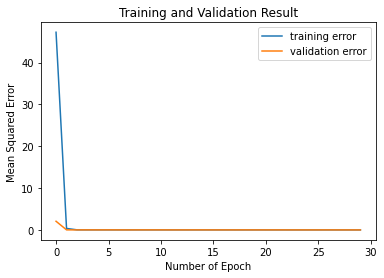

In [ ]:
plt.plot(tw_tr_history.history["mean_squared_error"], label = "training error")
plt.plot(tw_tr_history.history["val_mean_squared_error"], label = "validation error")
plt.xlabel('Number of Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Result')
plt.legend()

The graph is hard to follow, so we zoom in a bit to see the MSE's. 

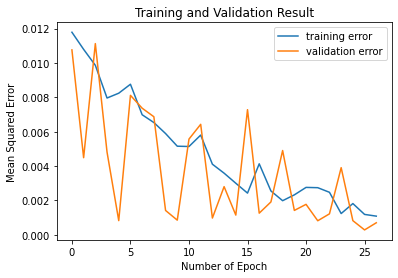

In [ ]:
plt.plot(tw_tr_history.history["mean_squared_error"][3:], label = "training error")
plt.plot(tw_tr_history.history["val_mean_squared_error"][3:], label = "validation error")
plt.xlabel('Number of Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Result')
plt.legend()

The validation errors fluctuate too much compared to the training error. There is possibility that the model is not converging well.

### Model Comparison: Twitter-Only and with Trading Information

For the model comparison, we use the validation MSE for comparison.

In [ ]:
tw_12_val = tw_history.history["val_mean_squared_error"]
tw_tr_val = tw_tr_history.history["val_mean_squared_error"]

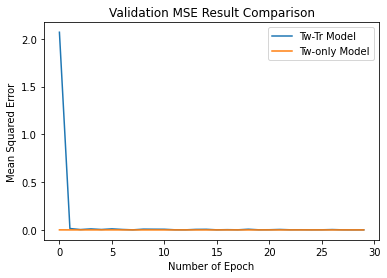

In [ ]:
plt.plot(tw_tr_val, label = "Tw-Tr Model")
plt.plot(tw_12_val, label = "Tw-only Model")
plt.xlabel('Number of Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Validation MSE Result Comparison')
plt.legend()

The graph is hard to follow, so we zoom in a bit to see the MSE's. 

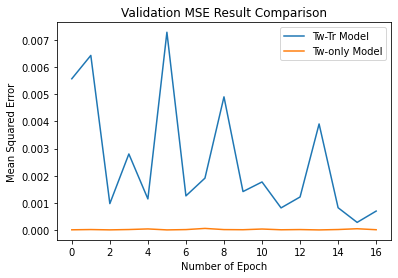

In [ ]:
plt.plot(tw_tr_val[3:], label = "Tw-Tr Model")
plt.plot(tw_12_val[3:], label = "Tw-only Model")
plt.xlabel('Number of Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Validation MSE Result Comparison')
plt.legend()

The Twitter-only model has much lower and much more stable MSE than the Twitter-TradingInfo model.

In [ ]:
# for twitter-only model, calculate MSE volatility
# use only epochs after 10
tw_12_val = tw_12_val[10:]
# create list recording volatility
tw_12_vol = []
# append volatility to the list
for i in np.arange(len(tw_12_val) - 1):
  volatility = tw_12_val[i+1] - tw_12_val[i]
  tw_12_vol.append(volatility)

# for twitter-tiprank model, calculate MSE volatility
# use only epochs after 10
tw_tr_val = tw_tr_val[10:]
# create list recording volatility
tw_tr_vol = []
# append volatility to the list
for i in np.arange(len(tw_tr_val) - 1):
  volatility = tw_tr_val[i+1] - tw_tr_val[i]
  tw_tr_vol.append(volatility)

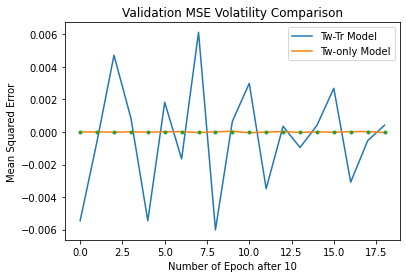

In [ ]:
plt.plot(tw_tr_vol, label = "Tw-Tr Model")
plt.plot(tw_12_vol, label = "Tw-only Model")
plt.plot(np.zeros(len(rd_tw_vol)), ".")
plt.xlabel('Number of Epoch after 10')
plt.ylabel('Mean Squared Error')
plt.title('Validation MSE Volatility Comparison')
plt.legend()

The y-axis actually represents the "change in MSE", i.e. volatility. From the graph we see that the Twitter-only model has much more stable volatility than the Twitter-TradingInfo model.

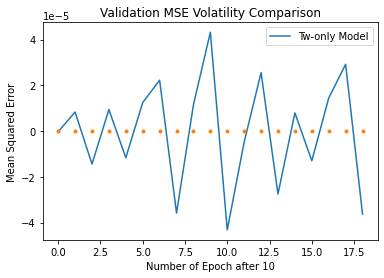

In [ ]:
plt.plot(tw_12_vol, label = "Tw-only Model")
plt.plot(np.zeros(len(tw_12_vol)), ".")
plt.xlabel('Number of Epoch after 10')
plt.ylabel('Mean Squared Error')
plt.title('Validation MSE Volatility Comparison')
plt.legend()

The y-axis actually represents the "change in MSE", i.e. volatility. To make sure that the Twitter-only model is not a "false model" with a 0 MSE, we also zoom in to see the fluctuation. It turns out that the Twitter model does have non-zero volatility.

### A Potential Discussion

Although trading information is generally considered to be effective here, the model result shows that trading info only creates more chaos to the model system. We were trying to discover potential reason here, and we realized that since the return prediction is on a daily basis, providing weekly trading information might lowers the model accuracy. That is, the "short-term" trading information we've retrieved is not the actual short-term information. We need access to daily trading information updates to further analyze on whether having trading information could improve the model.

## Conclusion and Significant Findings

At first, we decided to integrate historical returns, Tweets, Reddit posts, and weekly trading information from Tipranks for the prediction of future returns of a stock on a daily basis.

After comparisons between models with and without using Reddit posts as input, and between models with and without using weekly trading information as input, we confirm that using Twitter only is the optimal choice among all of our choices. Consequently, we decide to include Tweet data and exclude Reddit data and Tipranks data in our final model.